# Testing the PyFreatboard API

**PyFreatboard** was intended to have a simple way to draw freatboard diagrams (aka shapes) using Python. Most of the available solutions use SVG as the graphics engine while I wanted something based on Matplotlib.

## Defining a shape

Shapes (or diagrams) are composed of Fingers. Therefore, there is a 
* `Finger` class to define a finger position, harmonic function, fingering, ... and 
* a `Shape` class that contains a set of fingers.

In [ ]:
from PyFreatboard.finger import Finger
from PyFreatboard.shape import Shape
from PyFreatboard.draw_shape import DrawShape
from PyFreatboard.definitions import PyFreatboard as PF

f1 = Finger(pitch='C', function='1', string='E', freat=8, finger='2')
f2 = Finger(pitch='E', function='3', string='A', freat=7, finger='1')
f3 = Finger(pitch='G', function='5', string='A', freat=10, finger='4')
f4 = Finger(pitch='C', function='1', string='D', freat=10, finger='4')
c_shape = Shape([f1, f2, f3, f4])
c_shape.type = PF.SHAPE_TYPE['STRUM']

# Draw diagram showing harmonic function
draw = DrawShape()
f = draw.draw(c_shape, text=PF.TEXT_FUNCTION, return_fig=True)
f.savefig('shape.png', bbox_inches='tight')

# Draw diagram showing fingering and shape name
draw.draw(c_shape, text=PF.TEXT_FINGER, shape_name="C Major")

# Draw diagram showing Note name in vertical--> WARNING! Notes are show using enharmony! 
draw_v = DrawShape(freat_size=15) # For vertical diagrams it is better reduce freat_size from 20 to 15
draw_v.draw_vertical(c_shape, text=PF.TEXT_PITCH, show_string_names=True) # In vertical mode string names are by default disables


In [ ]:
from PyFreatboard.draw_score import DrawScore

ds = DrawScore()
ds.draw(c_shape)
del ds

## Automatic shape generation

Since defining the *fingers* one by one is tedious, there is a `BuildShape` class that can generate them automatically.

The class follows the following steps:

* Given a root and a shape type (defined in the `shapes.csv` file), it generates all shape notes.
* Finds at which position on the freatboard these notes can be played.
* Recursively, all sets of shapes are generated in which the lower freat and the upper freat are within six or less of each other.
* An automatic fingering algorithm is used to assign with which finger to play each note.
* The resulting shapes are filtered using various heuristics to keep only the most playable shapes.

With the current fingering and filtering rules, the algorithm can generate the standard *Berklee* shapes plus some additional shapes that are variants of them. By modifying these rules, other shapes/fingerings could be created.

In [ ]:
from PyFreatboard.build_shape import BuildShape
from PyFreatboard.draw_shape import DrawShape
from PyFreatboard.definitions import PyFreatboard as PF

shapes = BuildShape(root='C', shape_type='dism')
draw = DrawShape()

for e, shape in enumerate(shapes.all_shapes):
    if shape.valid:
    # if e in [8, 23, 30, 41, 54, 59]:
        print(e)
        draw.draw(shape, text=PF.TEXT_FUNCTION, return_fig=False)
        # f.savefig('penta_{}.png'.format(e), bbox_inches='tight')
        # print(shape.to_xml())


In [ ]:
from PyFreatboard.build_shape import BuildShape
from PyFreatboard.draw_shape import DrawShape
from PyFreatboard.definitions import PyFreatboard as PF

c7_drop2 = BuildShape(root='C', shape_type='Maj7')
drops = c7_drop2.build_drop(drop=2, bass_string="D")
draw = DrawShape(freat_size=15)
for d in drops:
    if d.valid:
        draw.draw_vertical(d, text=PF.TEXT_PITCH)
        # print(d.to_xml())


## Import song from SongXML file

Import a shapes defined using SongXML file and genertate shapes for its scales (arpeggios and drops to be done).

In [14]:
from PIL import Image
import numpy as np

def get_first_black_pixel(data):
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i, j] != 255:
                print(data[i,j])
                return i

def get_last_black_pixel(data):
    for i in range(data.shape[0]-1, 0, -1):
        for j in range(data.shape[1]):
            if data[i, j] != 255:
                return i

def crop_image(name):
    img = Image.open(name).convert('L')
    data = np.array(img)
    first = get_first_black_pixel(data)
    last = get_last_black_pixel(data)
    img1 = img.crop((0, first, data.shape[1], last))
    img1.save("crop_" + name)

In [ ]:
from PyFreatboard.song import Song
from PyFreatboard.draw_shape import DrawShape
from PyFreatboard.definitions import PyFreatboard as PF
from PyFreatboard.draw_score import DrawScore

# names = ['Ionian', 'Dorian', 'Lydian', 'Mixolydian', 'Aeolian', 'Locrian']
# names = ['Pentatonic Maj', 'Pentatonic']
names = ['Lydianb7', 'Mixolydianb9#9b13']
draw = DrawShape()
ds = DrawScore()
song = Song("/home/narcis/PyFreatboard/shapes_xml/modes.xml")
    
for name in names:
    # name="Mixolydian"
    shapes = song.get_scale_type_at_root(name, 'C')
    for i, s in enumerate(shapes):
        f = draw.draw(s, text=PF.TEXT_FUNCTION, return_fig=True)
        f.savefig(name + "_C_{}.png".format(i+1), dpi=300, bbox_inches='tight', pad_inches=0)
        fs = ds.draw(s, fingering=True, return_fig=True)
        fs.savefig(name + "_C_score_{}.png".format(i+1), dpi=600, bbox_inches='tight', pad_inches=0)
        crop_image(name + "_C_score_{}.png".format(i+1))
    

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


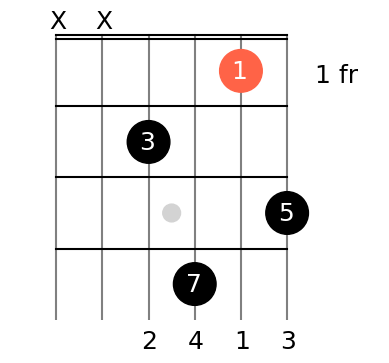

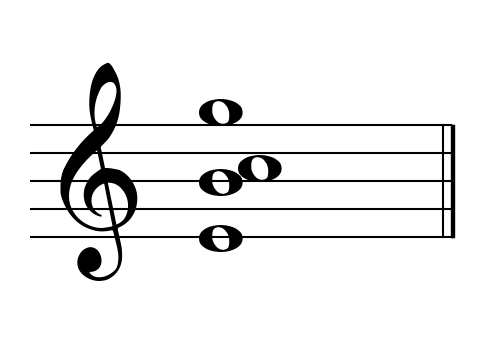

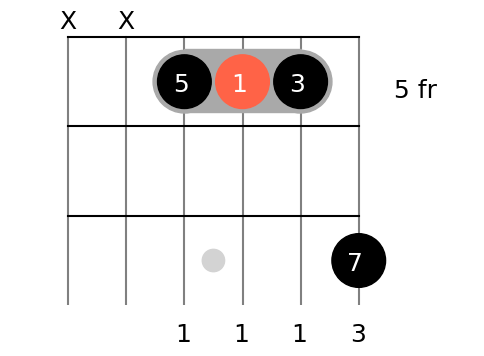

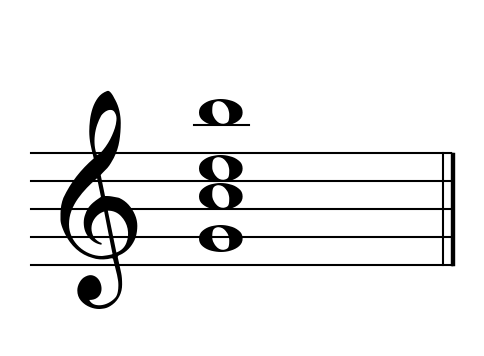

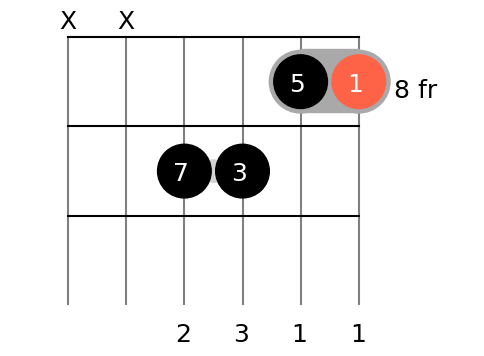

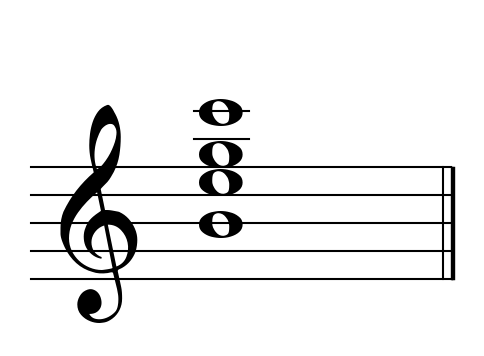

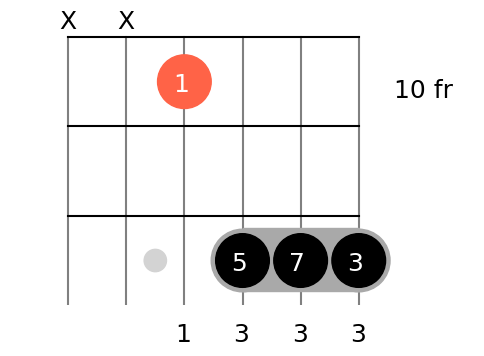

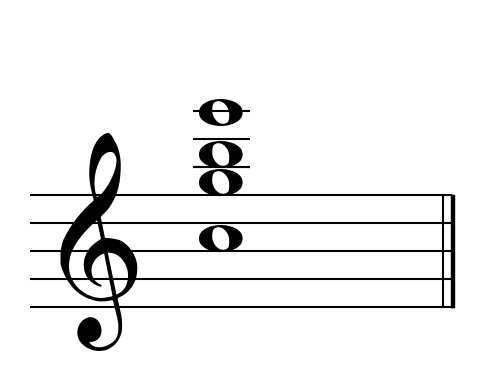

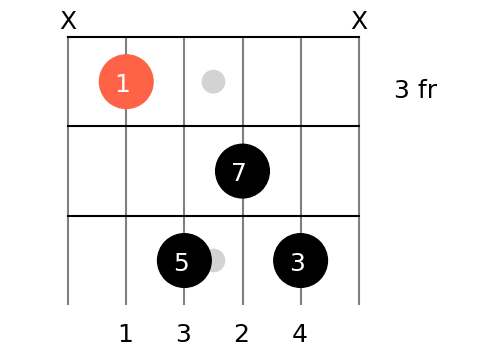

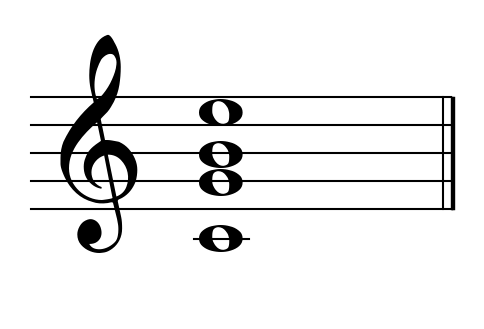

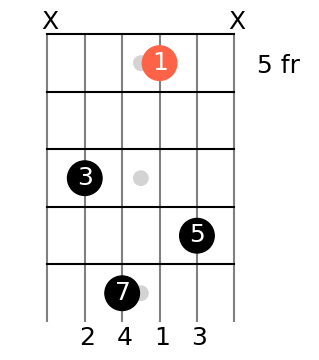

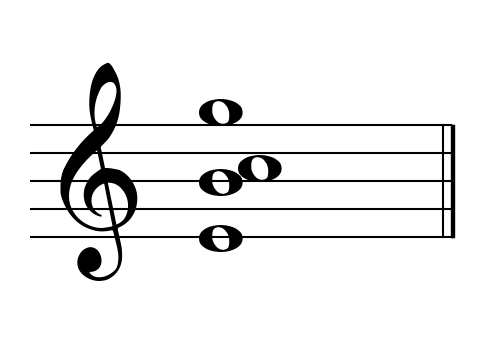

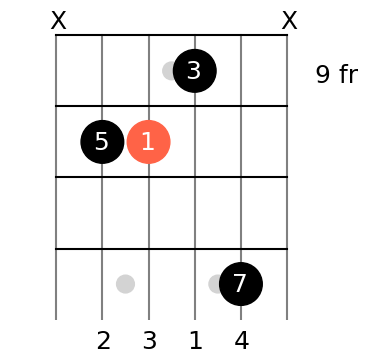

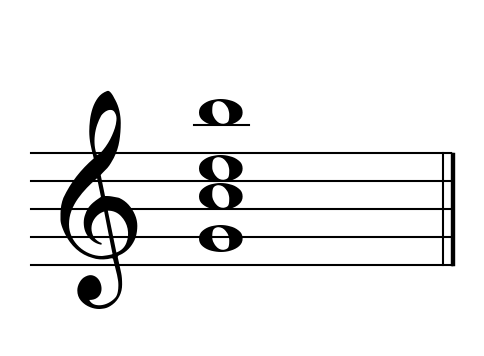

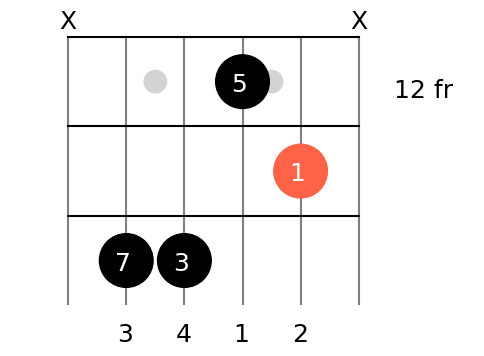

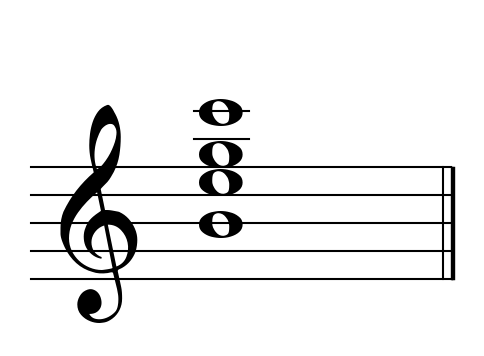

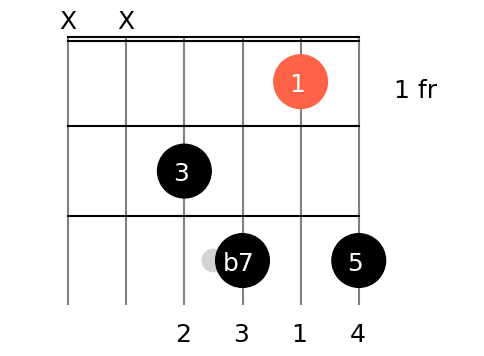

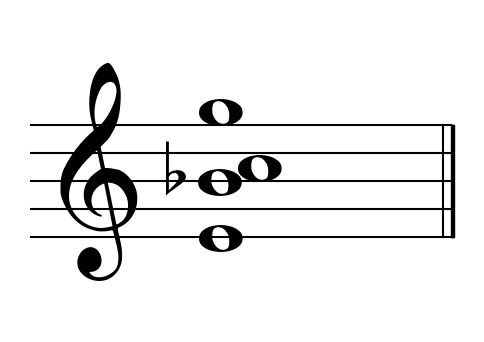

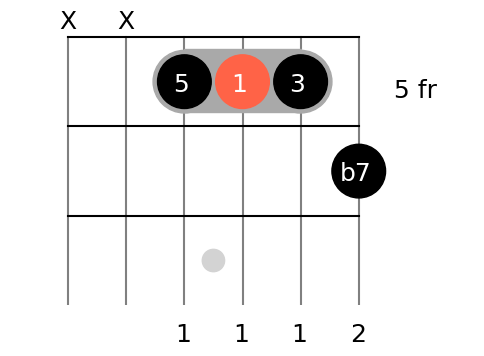

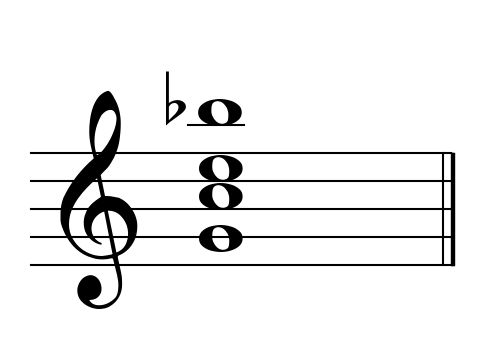

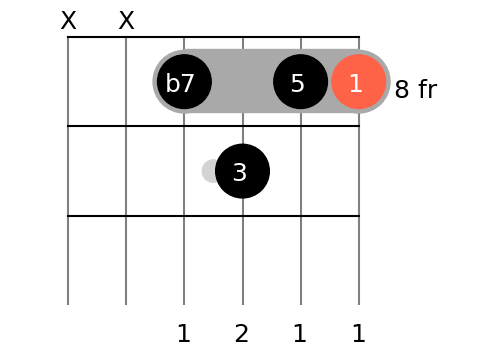

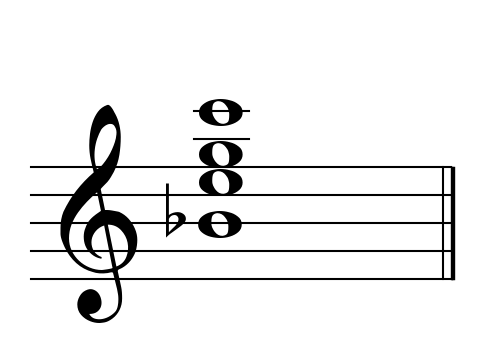

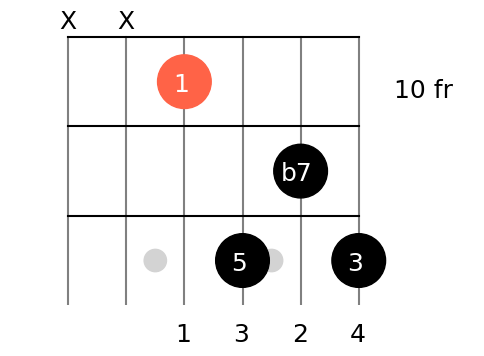

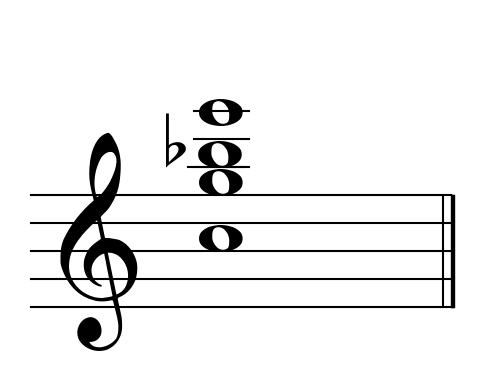

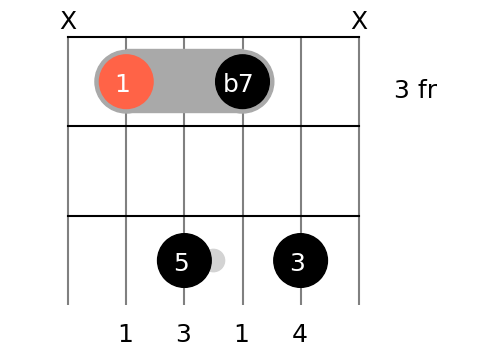

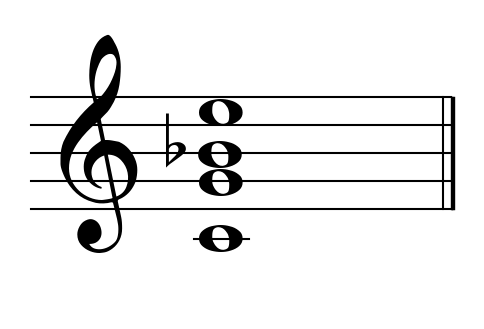

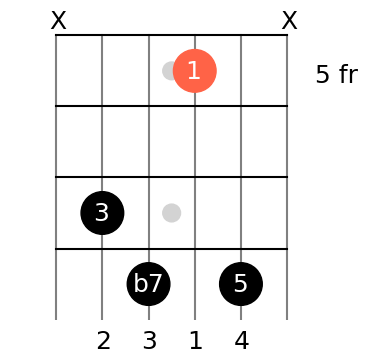

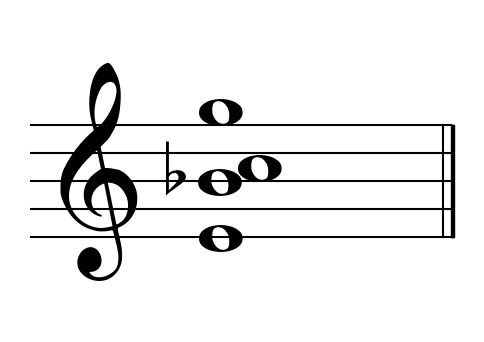

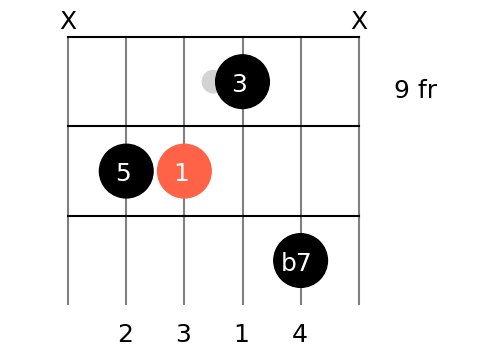

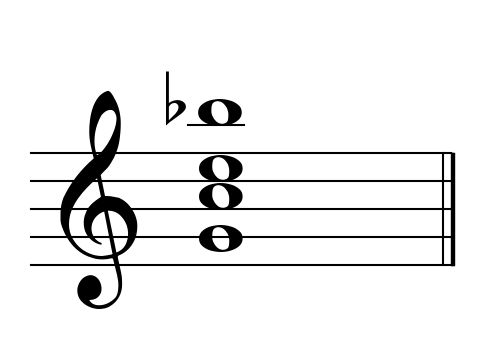

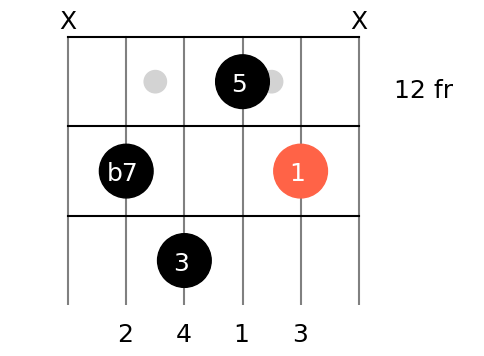

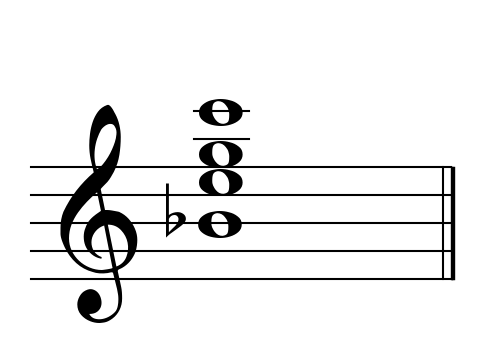

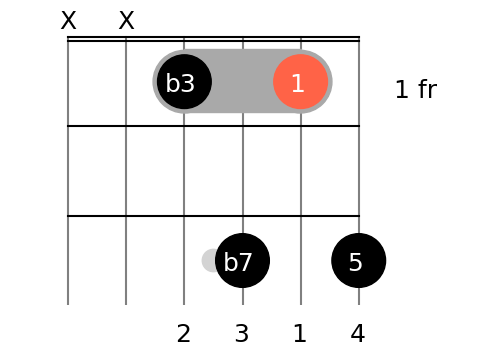

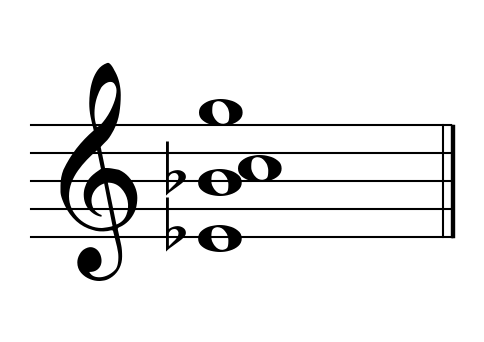

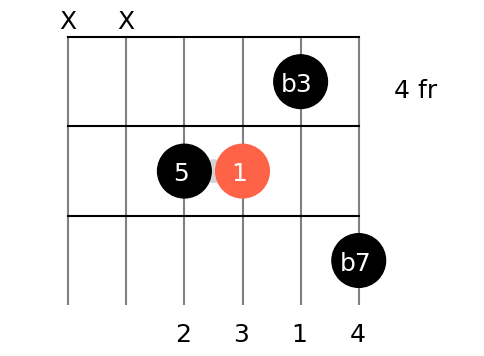

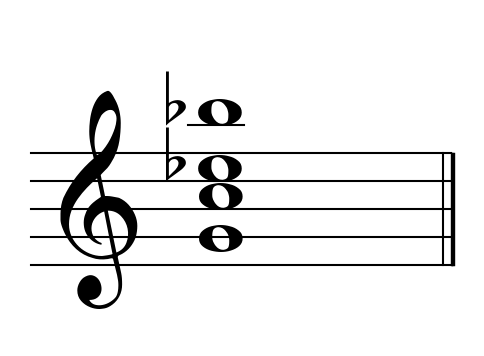

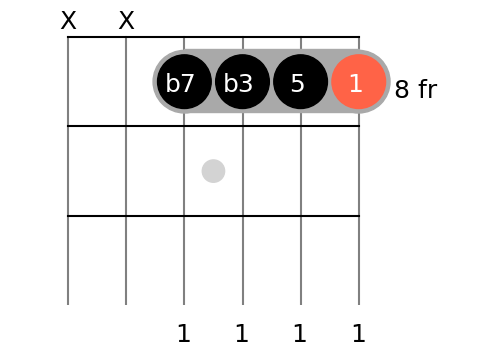

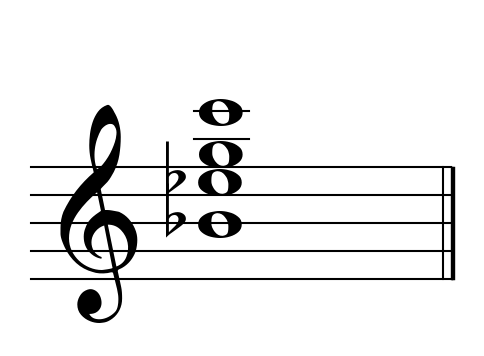

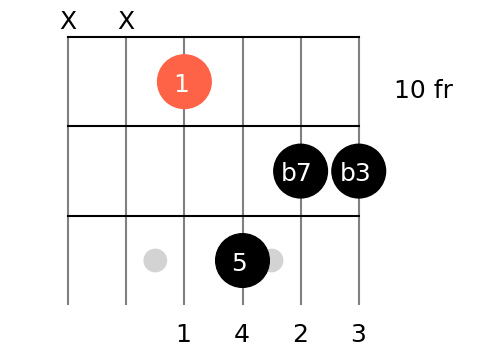

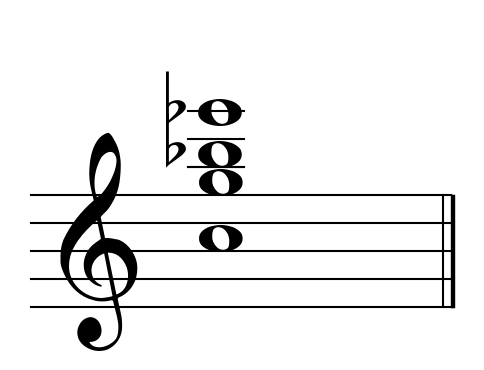

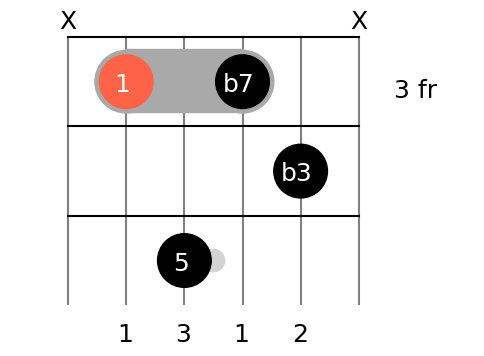

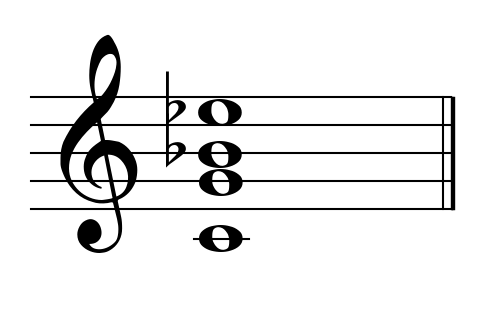

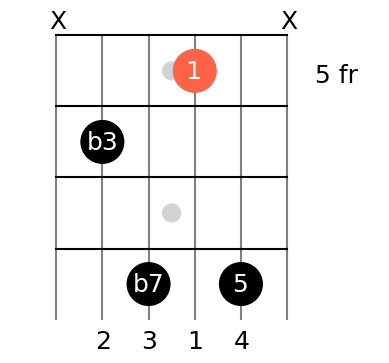

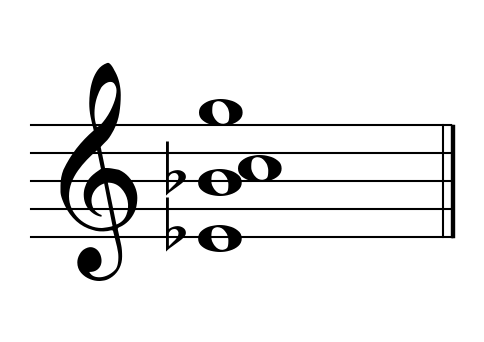

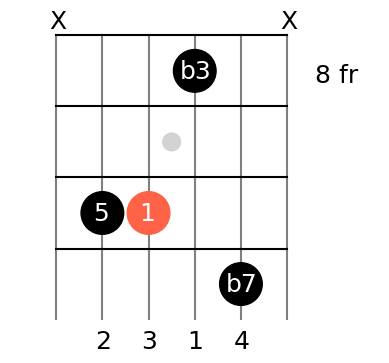

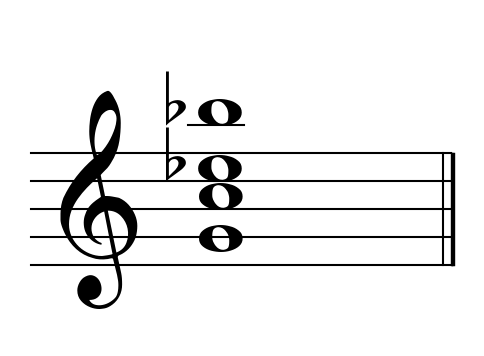

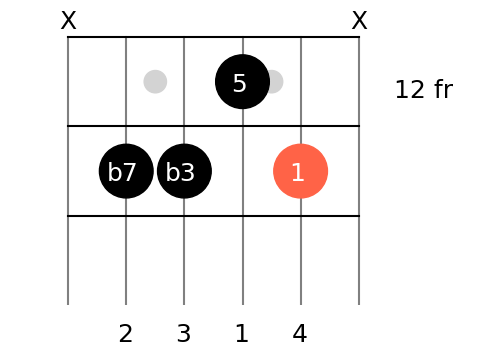

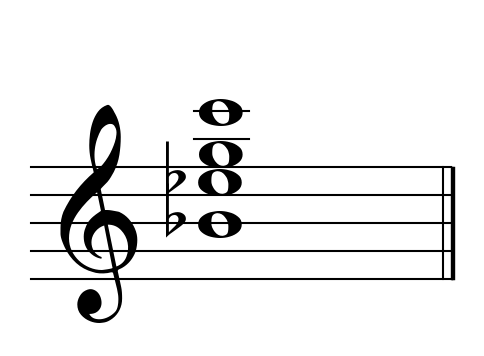

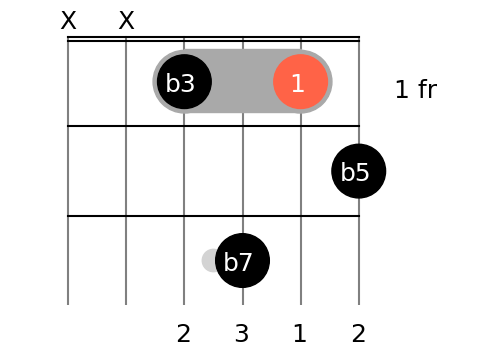

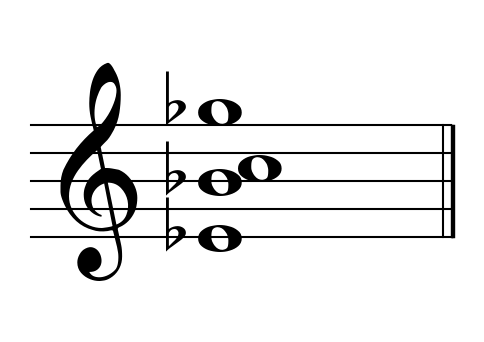

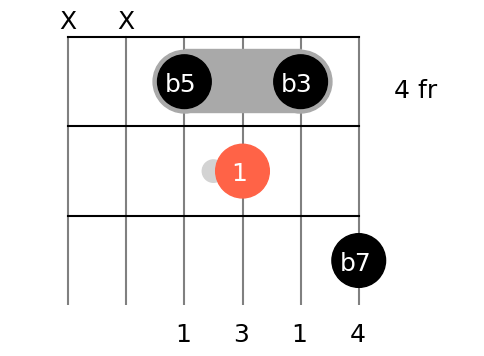

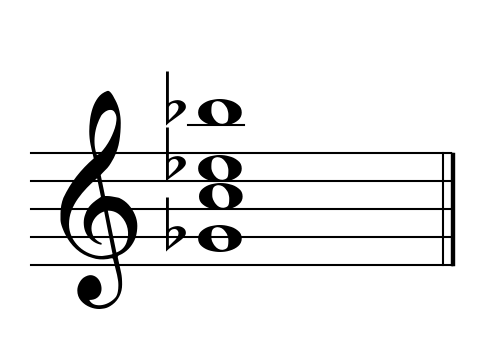

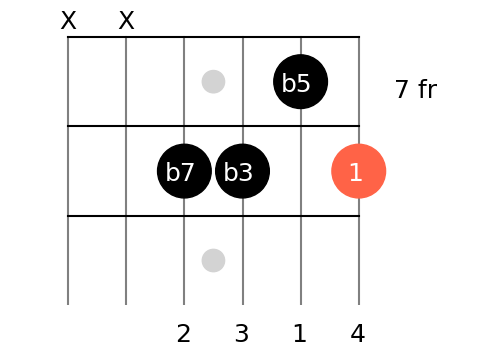

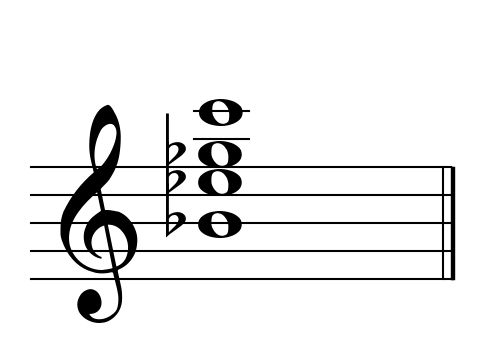

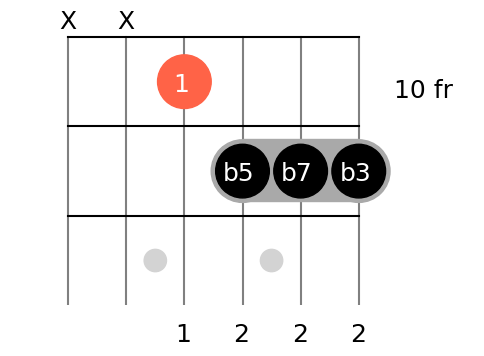

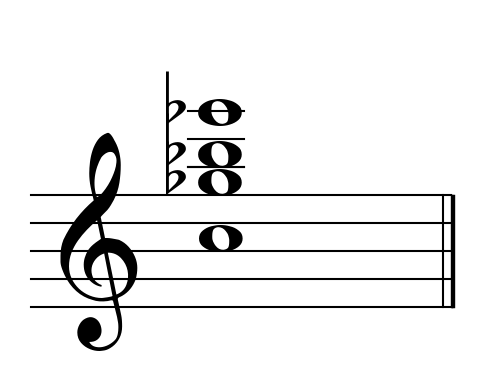

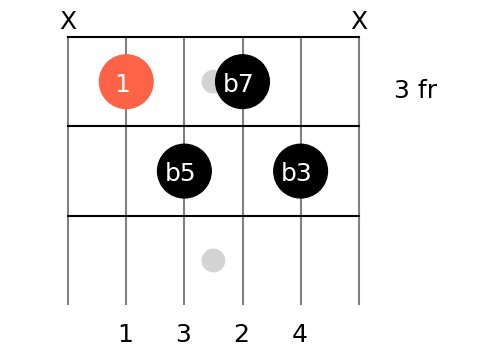

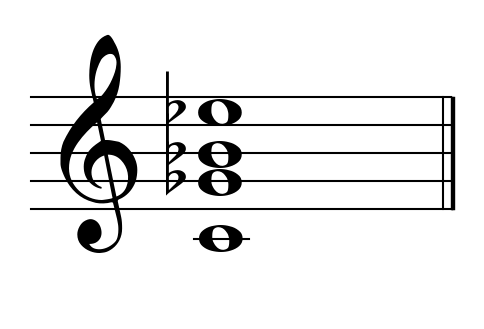

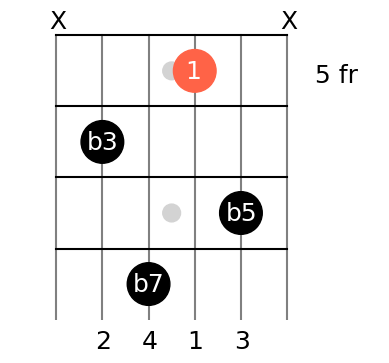

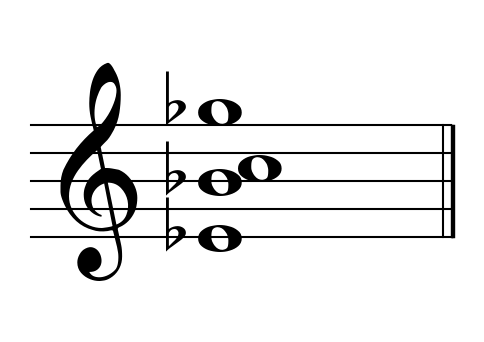

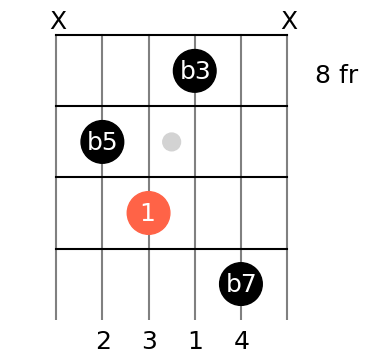

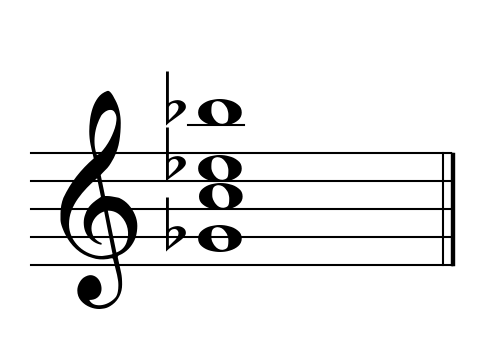

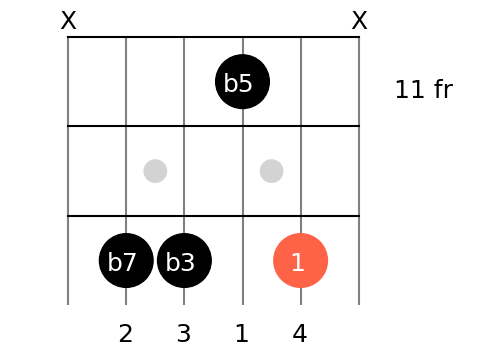

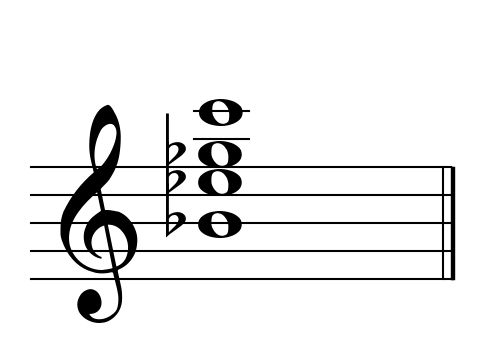

In [17]:
# Draw chords

from PyFreatboard.song import Song
from PyFreatboard.draw_shape import DrawShape
from PyFreatboard.definitions import PyFreatboard as PF
from PyFreatboard.draw_score import DrawScore

draw = DrawShape()
song = Song("/home/narcis/PyFreatboard/shapes_xml/drop2.xml")
shapes = song.chord_shapes
ds = DrawScore()

for i, k in enumerate(shapes.keys()):
    s = song.chord_shapes[k]
    f = draw.draw_vertical(s, text=PF.TEXT_FUNCTION, return_fig=True)
    f.savefig("triads{}.png".format(k), dpi=300, bbox_inches='tight', pad_inches=0)
    fs = ds.draw(s, fingering=False, return_fig=True)
    fs.savefig("triads{}_score.png".format(k), dpi=600, bbox_inches='tight', pad_inches=0)
    crop_image("triads{}_score.png".format(k))
    

In [ ]:
from PyFreatboard.song import Song
from PyFreatboard.draw_shape import DrawShape
from PyFreatboard.definitions import PyFreatboard as PF
from PyFreatboard.draw_score import DrawScore

draw = DrawShape()
ds = DrawScore()
song = Song("/home/narcis/PyFreatboard/shapes_xml/modes.xml")
tones = ['C'] #, 'D', 'E', 'F', 'G', 'A', 'B']
modes = ['Ionian', 'Dorian', 'Frigian', 'Lydian', 'Mixolydian', 'Aeolian', 'Locrian'] # , 'Mixolydianb9#9b13', 'Lydianb7'

for t in tones:
    for m in modes:
        shapes = song.get_scale_type_at_root(m, t)
        for i, s in enumerate(shapes):
            f = ds.draw(s, fingering=True, return_fig=True)
            f.savefig("{}_{}_{}.png".format(t, m, i), dpi=300, bbox_inches='tight', pad_inches=0)
